# Проект "Определение уровня удовлетворенности сотрудников"

**Описание проекта**:

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
 
Необходимо решить несколько задач:
 - Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
 - Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
 
Для решения поставленных задач заказчик предоставил данные с признаками:
 - id — уникальный идентификатор сотрудника;
 - dept — отдел, в котором работает сотрудник;
 - level — уровень занимаемой должности;
 - workload — уровень загруженности сотрудника;
 - employment_years — длительность работы в компании (в годах);
 - last_year_promo — показывает, было ли повышение за последний год;
 - last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
 - supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
 - salary — ежемесячная зарплата сотрудника;
 - job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.
 - quit - признак увольнения сотрудника,целевой признак.


In [1]:
#установим некоторые доп библиотеки
!pip install scikit-learn==1.1.3 -q
!pip install phik -q
!pip install shap -q
!pip install optuna -q
!pip install matplotlib==3.5.2 -q
!pip install optuna-integration -q

In [2]:
#импортируем необходимые библиотеки,отключим предупреждения (в конце), 
#зададим формат вывода знаков после запятой

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import sklearn
import shap
import optuna
import os 
from scipy import stats as st
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,cross_val_score
from optuna.integration import OptunaSearchCV
from optuna import distributions
from sklearn.metrics import make_scorer

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler,\
LabelEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score, recall_score

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.svm import SVC


import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Задача: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

Загрузим файлы с данными:
 - Тренировочная выборка: train_job_satisfaction_rate.csv
 - Входные признаки тестовой выборки: test_features.csv
 - Целевой признак тестовой выборки: test_target_job_satisfaction_rate.csv

In [3]:
# функция загрузки данных из файлов
def download(file,sep=','):
    
    data = pd.DataFrame()
    
    path_1 = '/datasets/' + file + '.csv'
    path_2 = 'https://code.s3.yandex.net/datasets/' + file + '.csv'
    
    if os.path.exists(path_1):
        data = pd.read_csv(path_1,sep=sep)
    elif os.path.exists(path_2):
        data = pd.read_csv(path_2,sep=sep)
    
    return data

In [4]:
#загрузим данные из файла с тренировочной выборкой
train_rate = download('train_job_satisfaction_rate')

#выведем первые 5 строк
train_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
#загрузим данные из файла с входными данными тестовой выборки
test_features = download('test_features')

#выведем первые 5 строк
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [6]:
#загрузим данные из файла с целевым признаком тестовой выборки
test_rate = download('test_target_job_satisfaction_rate')

#выведем первые 5 строк
test_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


На первый взгляд в таблицах с  данными все в порядке

### Предобработка данных

In [7]:
#выведем общую информацию тренинговой выборки
train_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Таблица представлены 10 столбцами и 4000 строк, в столбцах с отделом и уровнем занимаемой должности есть пропуски.Тип данных корректный

In [8]:
#выведем общую информацию о тестовой выборке
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Столбцов 9(те же самые, кроме целевого признака), строк 2000, есть пропуски в столбцах с названием отдела и уровне занимаемой должности. Тип данных корректный

In [9]:
#выведем общую информацию о целевом признаке тестовой выборки
test_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


2 столбца, 2000 строк, пропусков нет, тип данных корректный.

Выведем строки с пропусками(сначала по столбцу отдел, затем уровень занимаемой должности)

In [10]:
#выведем строки с пропусками в строке с отделом
train_rate[train_rate['dept'].isna()].sort_values(by='salary')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63


In [11]:
#выведем строки с пропусками в строке с уровнем должности
train_rate[train_rate['level'].isna()].sort_values(by='salary')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


Итак:
 - пропускам по столбцу отдел соответствует уровень джуниор, по уровню загруженности представлены все варианты, 
 - пропускам по столбцу уровень загруженности соответствует только отдел продаж, по уровню загруженности низкий и средний.

Также оценим пропуски для тестовой выборки

In [12]:
#выведем все строки с пропусками тестовой выборки
test_features[test_features['dept'].isna()|test_features['level'].isna()].sort_values(by='salary')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


Поскольку по столбцам last_year_promo,last_year_violations,supervisor_evaluation практически невозможно определить ни отдел, ни уровень занимаемой должности, employment_years скорее всего тоже не характеризуют уровень занимаемой должности (например,джуны в представленных пропусках работают и 1 год, и 3) - попробовать определить отдел и уровень должности можно попробовать по уровню заработной платы. 

Оценим "вилку" заработной платы (минимальную и максимальную величину)  для отдела продаж с учетом уровня занимаемой должности

In [13]:
#выведем сводную таблицу для отдела продаж с миинимальной и максимальной зарплатой по уровням
train_rate.query('dept=="sales"')\
.pivot_table(index='workload',columns='level',values='salary',aggfunc=['min','max'])

min                  max              
level    junior middle sinior junior middle sinior
workload                                          
high      30000  45600  62400  38400  60000  79200
low       12000  18000  25200  19200  30000  39600
medium    20400  31200  43200  28800  44400  60000

In [14]:
#снова выведем строки с пропусками в строке с уровнем должности для удобства
print(train_rate[train_rate['level'].isna()][['workload','salary']].sort_values(by='salary'))
print(' ')
print(test_features[test_features['level'].isna()][['workload','salary']])

     workload  salary
1469      low   18000
1745   medium   26400
1209   medium   27600
2522   medium   27600
 
    workload  salary
312      low   12000


Тренинговая выборка:
 - Для низкого уровня загрузки з/плата соответствует как низкому уровню должности (он от 12000 до 19200), так и начальному среднему уровню должности (он от 18000), тяжело однозначно определить уровень должности. При этом для среднего уровня загрузки з/плата однозначно соответствует низкому уровню должности

Тестовая выборка:
- Данная з/плата однозначно соответствует низкому уровню должности.

Аналогично выведем "вилку" з/плат для низкого уровня должности (junior) по всем отделам

In [15]:
#выведем сводную таблицу по отделам для уровня должности junior с миинимальной и максимальной зарплатой
train_rate.query('level=="junior"')\
.pivot_table(index='workload',columns='dept',values='salary',aggfunc=['min','max'])

min                                           max            \
dept         hr marketing purchasing  sales technology     hr marketing   
workload                                                                  
high      32400     33600      31200  30000      37200  40800     43200   
low       12000     13200      12000  12000      14400  20400     21600   
medium    21600     22800      21600  20400      25200  31200     32400   

                                       
dept     purchasing  sales technology  
workload                               
high          40800  38400      48000  
low           20400  19200      24000  
medium        30000  28800      36000

In [16]:
#выведем строки с пропусками в строке с отделом
print(train_rate[train_rate['dept'].isna()][['workload','salary']].sort_values(by='salary'))
print(' ')
print(test_features[test_features['dept'].isna()][['workload','salary']])

     workload  salary
3866      low   12000
2975      low   18000
1526   medium   21600
1630   medium   24000
2781   medium   26400
1633     high   31200
 
     workload  salary
191    medium   20400
1196   medium   28800


Тренировочная выборка:
 - З/плата для низкого уровня загрузки соответствует нескольким отделам (12000 - трем,18000 - всем), как и для среднего(каждое значение соответствует от 2-м до 5-ти отделам), так и для высокого (подходят 2 отдела). Во всех случаях одно из совпадений отдел sales  и 	purchasing
 
Тестовая выборка:
- значение 20400 соответствует только отделу продаж, 28800 соответствует всем отделам.


Проверим данные на явные дубликаты

In [17]:
#выведем кол-во явных дубликатов
print(train_rate.duplicated().sum(), test_features.duplicated().sum(),test_rate.duplicated().sum())

0 0 0


Явные дубликаты отсутствуют.

Объединим тестовую выборку и целевой признак для тестовой выборки

In [18]:
test = test_features.merge(test_rate,on='id',how='left')
test.sample(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
128,826000,technology,middle,medium,4,no,no,4,40800,0.54
1471,319531,sales,junior,medium,2,no,no,3,20400,0.32
387,198471,purchasing,junior,low,3,no,no,4,15600,0.94
740,899943,technology,junior,medium,2,no,yes,3,30000,0.18
1205,970176,hr,junior,low,2,no,no,4,13200,0.70


Проверим на возможное совпадение id тренинговой и тестовой выборок

In [19]:
id_replaced = list(set(train_rate['id'].unique()) & set(test['id'].unique()))

id_replaced        

[]

Совпадение в id тренинговой и тестовой выборок - отсутствует.

Проверим на неявные дубликаты (опечатки в категориальных признаках)

In [20]:
#выведем уникальные значение из тренировочного файла
for column in train_rate.select_dtypes(exclude='number'):
    print (column,':',train_rate.select_dtypes(exclude='number')[column].unique())

dept : ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level : ['junior' 'middle' 'sinior' nan]
workload : ['medium' 'high' 'low']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']


Опечатки, некорректности в категориальных данных отсутствуют, наны - это пропуски ( заполним их в пайплайне).

Далее проверим для тестовой выборки

In [21]:
for column in test_features.select_dtypes(exclude='number'):
    print (column,':',test_features.select_dtypes(exclude='number')[column].unique())

dept : ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level : ['junior' 'middle' 'sinior' nan]
workload : ['medium' 'low' 'high' ' ']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']


Значения категориальных признаков в тестовой выборке совпадают с тренинговой, кроме еще одного сразу не выявленного типа пропусков - пробел. Посмотрим насколько много таких значений, они в столбцах с отделом и уровнем загрузки.

In [22]:
test_features[(test_features['dept']==' ')|(test_features['workload']==' ')]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


Эти значения являются неявными пропусками,также заполним их в пайплайне

Для строки с отделом dept и уровнем должности junior, з/платой 28800 - это средний уровень загрузки.
Чтобы определить отдел для 2-го пропуска выведем сводную таблицу по отделам с вилкой з/плат

In [23]:
train_rate.query('level=="middle" and workload=="medium"')\
.pivot_table(index='workload',columns='dept',values='salary',aggfunc=['min','max'])

min                                           max            \
dept         hr marketing purchasing  sales technology     hr marketing   
workload                                                                  
medium    33600     34800      32400  31200      38400  46800     48000   

                                       
dept     purchasing  sales technology  
workload                               
medium        45600  44400      52800

Как видим это может быть любой отдел.

**Вывод по итогу предобработки**:

 - Типы данных во всех датафреймах корректные.
 - Явные и неявные дубликаты отсутствуют.
 - Есть пропуски как в тренинговой, так и тестовой выборках в признаках отдел, уровень должности и уровень загрузки. Поскольку по столбцам last_year_promo,last_year_violations,supervisor_evaluation практически невозможно определить ни отдел, ни уровень занимаемой должности, employment_years тоже не характеризуют уровень занимаемой должности (например,джуны в представленных пропусках работают и 1 год, и 3) - определить отдел и уровень должности можно попробовать по уровню заработной платы, а именно вхождению в так называемую "зарплатную вилку"(минимальное и максимальное значение): 
   - Отдел: данному пропуску соответствуют преимущественно уровень должности junior  (кроме одного middle) и разные уровни загруженности. В зависимости от уровня загруженности з/плата сотрудников с пропусками может соответствовать от 2 до 5-ти отделам, во всех случаях одно из совпадений отдел sales  и 	purchasing. Далее решим будем ли мы заполнять пропуски наиболее частым значением (если sales  и/или purchasing к ним будут относится), либо будем игнорировать пропуски.
   - Уровень должности: пропуски в отделе sales, для среднего уровня загрузки значение соответствует всегда низкому уровню должности, одно значение низкого уровня загрузки - спорно, может быть и низкое и среднее.
   - Уровень загрузки: 1 пропуск,соответствует среднему уровню загрузки.

### Исследовательский анализ данных

Перейдем к исследовательскому анализу. Проанализируем сначала распределение признаков, далее корреляцию, после чего сделаем выводы о том, как нужно подготовить признаки.

####  Распределение признаков

Распределение категориальных признаков следующее

In [24]:
#создадим фукнцию для построения круговой диаграммы
def pie_1(df_1,df_2,column):
    df_1=df_1.pivot_table(index=column,values='id',aggfunc='count').reset_index()
    df_2=df_2.pivot_table(index=column,values='id',aggfunc='count').reset_index()
    
    fig, ax = plt.subplots(figsize = (20, 5))
    
    ax = plt.subplot(1, 2, 1)
    plt.pie(df_1['id'], autopct='%.1f%%', radius=0.75);
    plt.xlabel('Распределение в тренинговой выборке', fontsize=12);
    plt.legend(labels=df_1[column],loc='upper left', bbox_to_anchor=(1.5, 1.0));

    ax = plt.subplot(1, 2, 2)
    plt.pie(df_2['id'],autopct='%.1f%%', radius=0.75);
    
    plt.xlabel('Распределение в тестовой выборке', fontsize=12);
    #plt.legend(labels = df_2[column],loc='upper left', bbox_to_anchor=(1.0, 1.0));
    
    fig.suptitle('Распределение сотрудников по значению '+column,fontsize=14)
    plt.subplots_adjust(wspace=1,hspace = 1)
    plt.show()

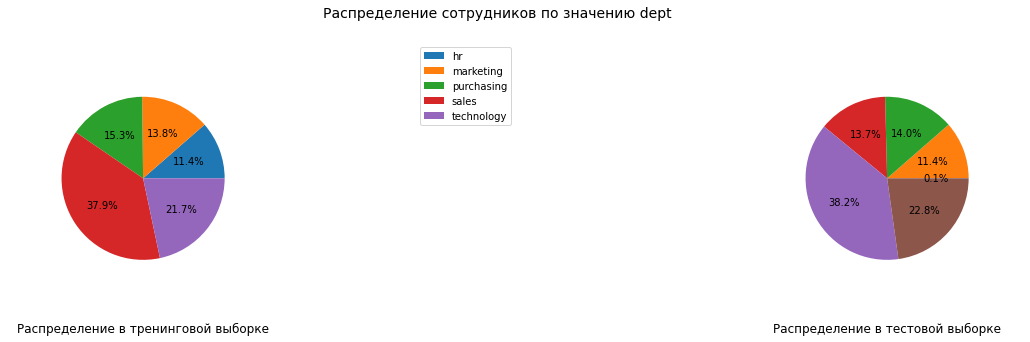

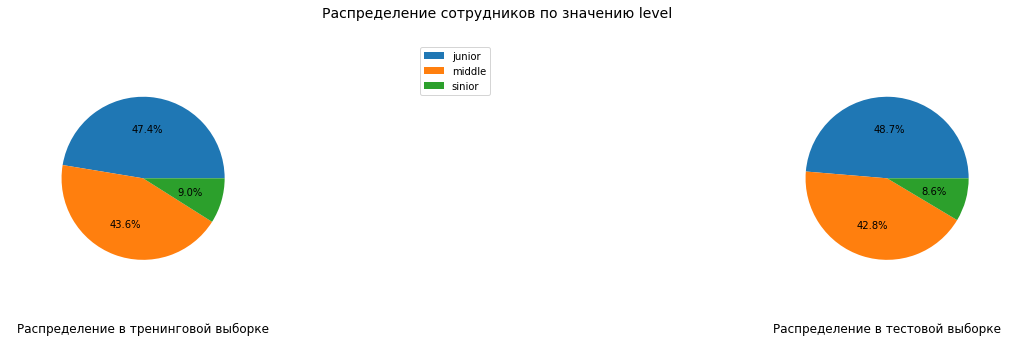

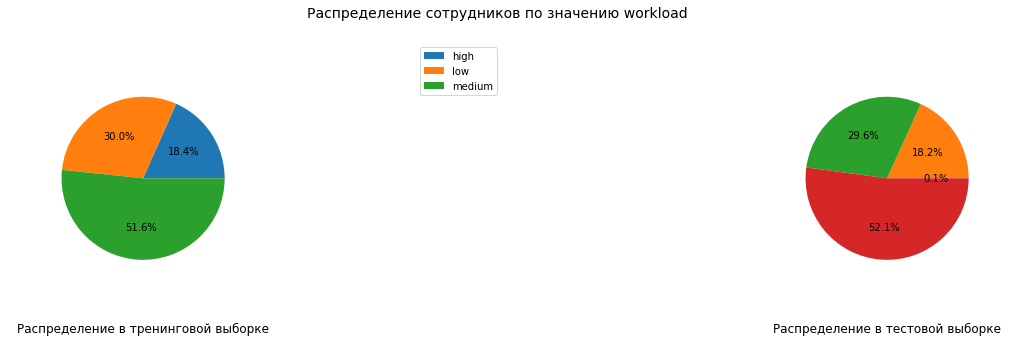

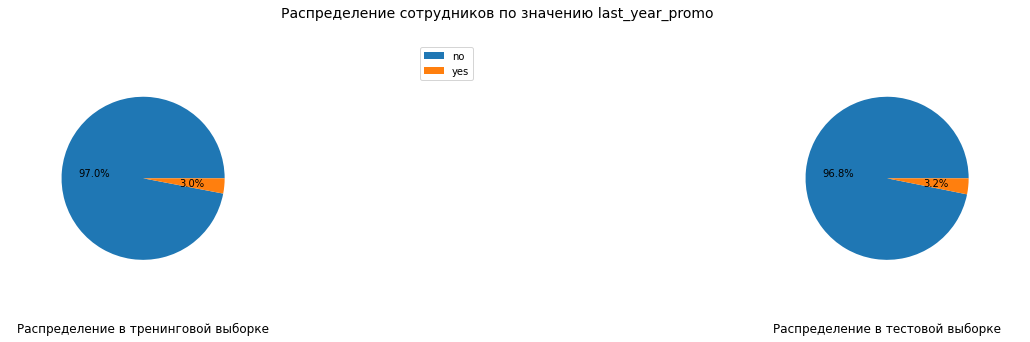

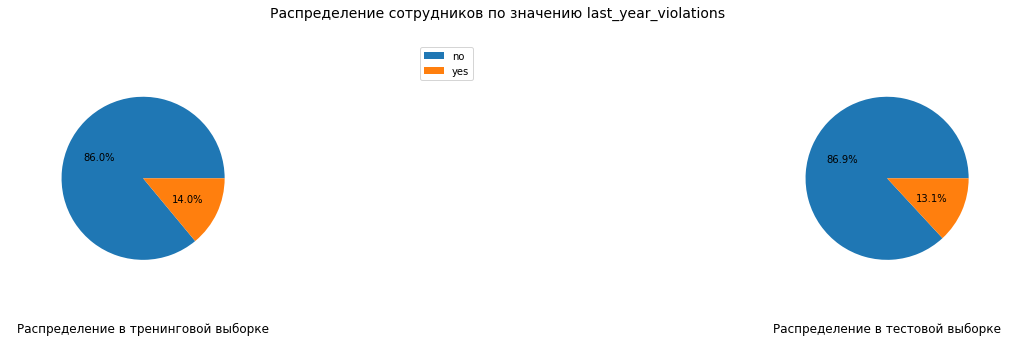

In [25]:
 #выведем 
for column in  train_rate.select_dtypes(exclude='number').columns.tolist():
    pie_1(train_rate,test_features.dropna(axis=0),column)

Распределение признаков в тестовой и тренинговой выборке в процетном соотношении очень похоже:
 - отдел: наиболее частое значение - sales(больше трети выборок), меньше всего - hr (11%),
 - уровень должности: наиболее частое значение - junior(47-48%), далее - middle (43-44%),меньше всего sinior(9%), распределение вполне ожидаемо и соответствует орг структуре многих крупных компаний,
 - уровень загрузки:наиболее частое - medium(52%), далее - low(30%), меньше всего - high (18%).
 - повышение за последний год: преимущественно нет (97%), да всего 3%.
 - нарушение трудового договора: преимущественно нет(86-87%), да всего 13-14%.
 
Данные в категориальных признаках несбалансированы, особенно это выражено в признаках повышение за последний год и нарушение трудового договора. 

Далее проанализируем данные по количественным показателям: сначала выведем статистику (для тестовой выборки предварительно объединим с целевым признаком)

In [26]:
#выведем статистику для тренинговой выборки
train_rate.drop(['id'],axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
employment_years,"4,000.00",3.72,2.54,1.00,2.00,3.00,6.00,10.00
supervisor_evaluation,"4,000.00",3.48,1.01,1.00,3.00,4.00,4.00,5.00
salary,"4,000.00","33,926.70","14,900.70","12,000.00","22,800.00","30,000.00","43,200.00","98,400.00"
job_satisfaction_rate,"4,000.00",0.53,0.23,0.03,0.36,0.56,0.71,1.00


In [27]:
#объединим таблицу в входными и целевым тестовыми признаками
test = test_features.merge(test_rate,on='id',how='left')
#выведем статистику для тестовой выборки
test.drop(['id'],axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
employment_years,"2,000.00",3.67,2.54,1.00,1.00,3.00,6.00,10.00
supervisor_evaluation,"2,000.00",3.53,1.00,1.00,3.00,4.00,4.00,5.00
salary,"2,000.00","34,066.80","15,398.44","12,000.00","22,800.00","30,000.00","43,200.00","96,000.00"
job_satisfaction_rate,"2,000.00",0.55,0.22,0.03,0.38,0.58,0.72,1.00


Статистика по столбцам в тренинговой и тестовой выборках схожа:
 - длительность работы: среднее значение 3.7 лет,медиана -3,минимальное значение -1, максимум - 10,
 - оценка руководителя: в среднем 3.5,медиана -4, минимум 1, максимум 5,
 - уровень з/плат: среднее значение 33,9-34 тыс.,медиана -30 тыс.,минимальное - 12 тысяч, максимум немного отличается ( 98,4 и 96 тыс),
 - уровень удовлетворенности: среднее 0.53 и 0.55,медиана -0.56 и 0.58,минимум - 0.03, максимум - 1.
 
 Далее визуализируем распределение количественных признаков (выведем диаграммы распределения и боксплоты). Сначала для тренинговой выборки 

In [28]:
#создадим фукнцию для построения гистограммы распределения и диаграммы размаха
def hist_box(df,column):
    fig, ax = plt.subplots(figsize = (15, 5))
    
    df.plot(y =column,\
          kind ='hist', ec='black', bins = 30, grid = True,ax = plt.subplot(1, 2, 1));
    plt.ylabel('Кол-во сотрудников', fontsize=12);
    plt.xlabel(column, fontsize=12);
    plt.xlim((df[column].min()*0.9,df[column].max()*1.1))

    df.boxplot(column,ax = plt.subplot(1, 2, 2))
    plt.ylim((df[column].min()*0.9,df[column].max()*1.1))
    plt.ylabel(column, fontsize=12);
    
    fig.suptitle('Распределение и размах по значению '+column)
    plt.subplots_adjust(wspace=0.5,hspace = 0.5)
    plt.show()

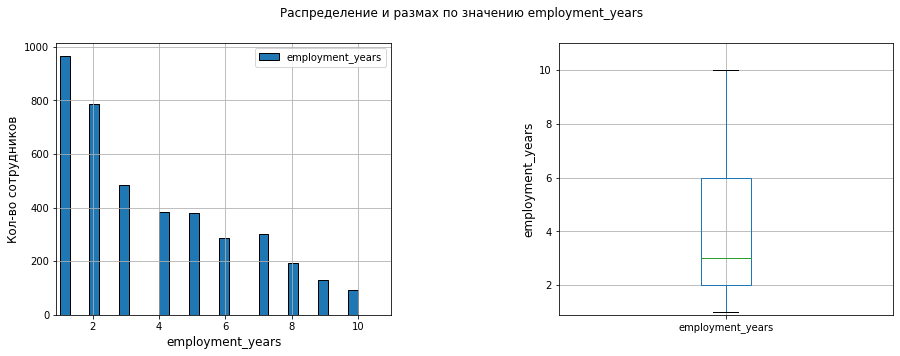

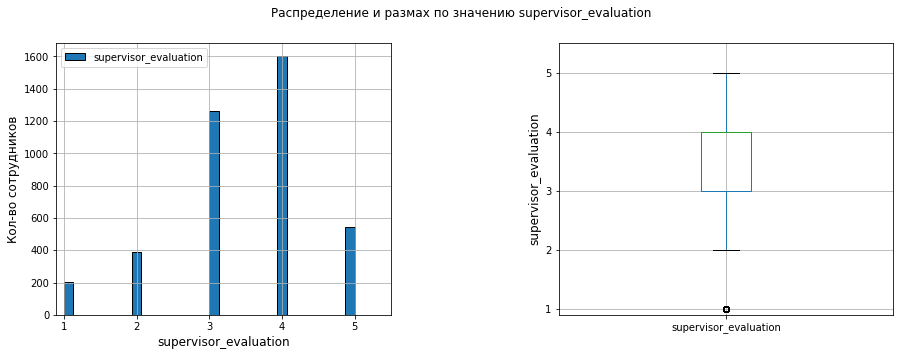

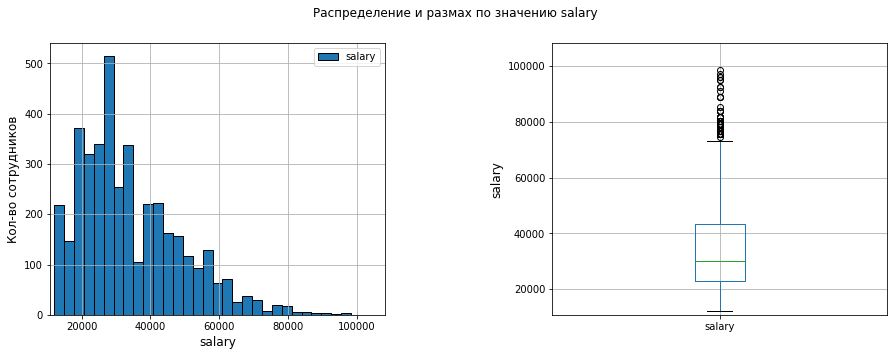

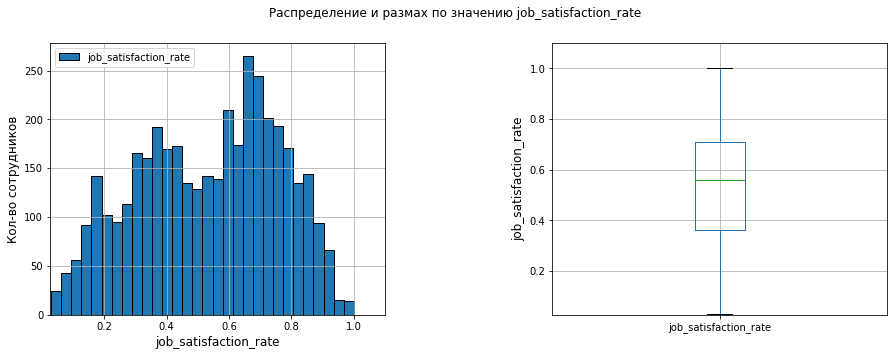

In [29]:
 #выведем гистограмму распределения и диаграмму размаха
for column in  train_rate.drop(['id'],axis=1).select_dtypes(include='number').columns.tolist():
    hist_box(train_rate.drop(['id'],axis=1).select_dtypes(include='number'),column)

 - длительность работы: наиболее частое значение 1, далее чем выше срок, тем меньше кол-во сотрудников,75% - работают не более 6 лет, четверть от 6 до 10,
 - оценка руководителя: наиболее частое значение 4, далее 3, 1 ставится очень редко,
 - уровень з/плат: наиболее частое значение - около 30 тысяч, свыше примерно 72 тысяч (выбросы по боксплоту) - это з/плата персонала высокого уровня, не стоит считать это аномалией или выбросом,
 - уровень удовлетворенности: распределение нормальное с двумя пиками, наиболее частое значение - 0.65 

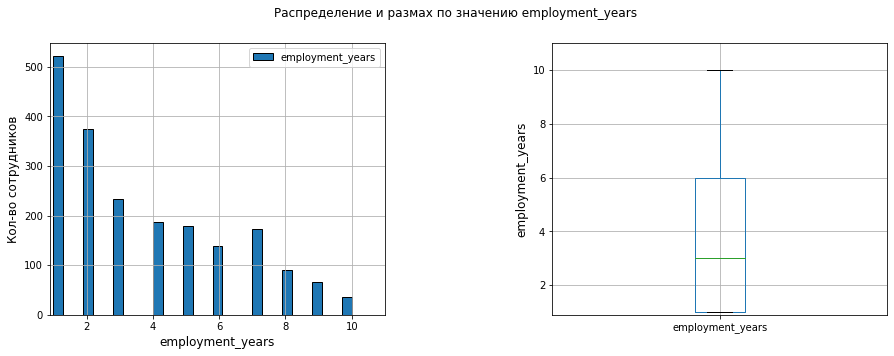

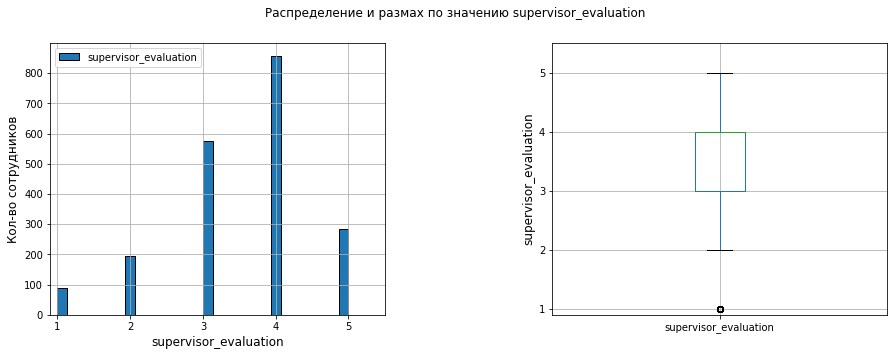

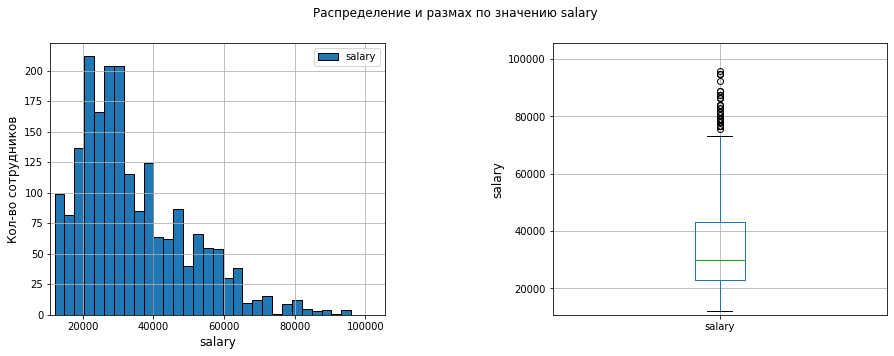

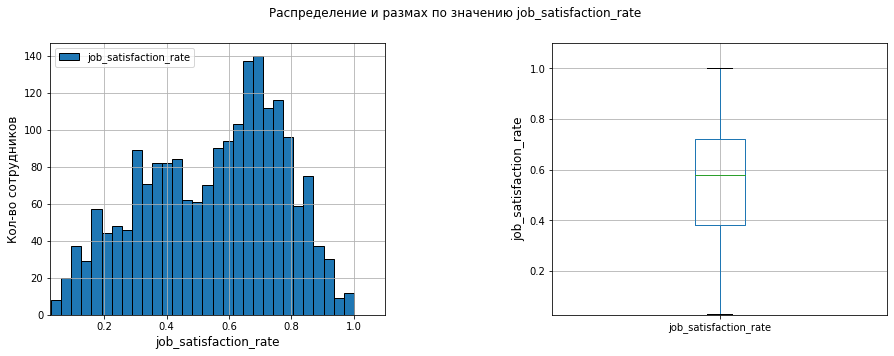

In [30]:
#выведем гистограмму распределения и диаграмму размаха для тестовой выборки
for column in  test.drop(['id'],axis=1).select_dtypes(include='number').columns.tolist():
    hist_box(test.drop(['id'],axis=1).select_dtypes(include='number'),column)

 Распределение  количественных признаков почти такое же, как в тренинговой, небольшие отличия следующие:
 - длительность работы: в тренинговой первый квартиль на значении 1 год, в тестовой - 2 года.

#### Корреляция признаков

Оценим корреляцию всех признаков для тренинговой и тестовой выборки, далее сравним результат

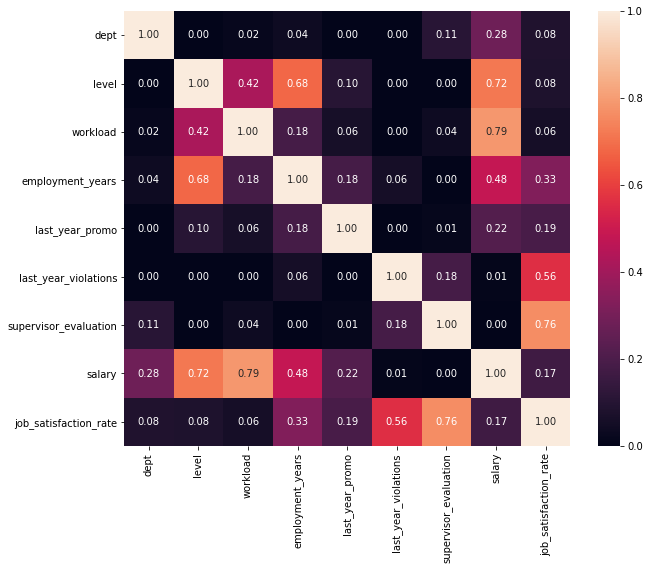

In [31]:
#построим матрицу корреляции
fig, ax = plt.subplots(figsize=(10, 8));
sns.heatmap(
    train_rate.drop(['id'],axis=1).phik_matrix(
    interval_cols =['employment_years','salary', 'job_satisfaction_rate']
),
ax=ax, annot=True, fmt='.2f'
);

 - Корреляция между признаками 0.9 и выше отсутствует, т.е. мультиколлинеарности нет,
 - С уровнем удовлетворенности наиболее коррелируют оценка качества работы руководителем (коэф-т 0.76),нарушения трудового договора(коэф-т 0.56) и длительность работы в компании(коэф-т 0.33), практически отсутствует корреляция с уровнем загрузки(коэф-т 0.06), отделом и уровнем должности(коэф-т 0.08). С уровнем з/платы и повышением за последний год корреляция слабая

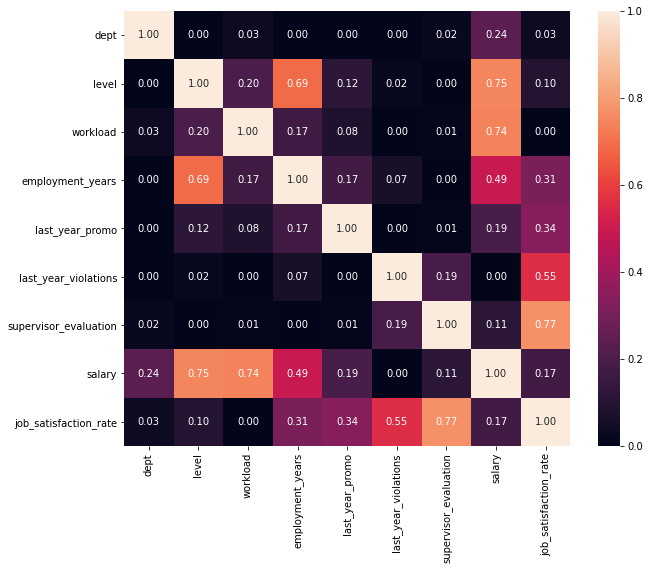

In [32]:
#построим матрицу корреляции
fig, ax = plt.subplots(figsize=(10, 8));
sns.heatmap(
    test.drop(['id'],axis=1).phik_matrix(
    interval_cols =['employment_years','salary', 'job_satisfaction_rate']
),
ax=ax, annot=True, fmt='.2f'
);

 - Мультиколлинеарность также отсутствует. 
 - Корреляция с уровнем удовлетворенности: получены схожие коэф-ты корреляции для наиболее и наименее влияющих признаков, при этом с повышением за последний год коэф-т чуть выше, чем в тренинговой выборке.
 
В целом можно сказать, что наиболее высокая корреляция удовлетворенности прослеживается с оценкой качества руководителем и нарушением трудового договора, самая низкая - с отделом, уровне должности и загрузки. 

Построим также диаграммы рассеивания удовлетворенности и всех остальных признаков для тренинговой выборки в разбивке на категории внутри категориальных признаков

In [33]:
#напишем функцию для диграммы рассеивания с подсветкой разных значений категориального признака
def scatter(z,column):
    groups = train_rate.groupby(z)
    for name, group in groups:
        plt.scatter(group[column], group['job_satisfaction_rate'], marker='o',label=name)
        plt.title(column)
        plt.xlabel(column)
        plt.legend()

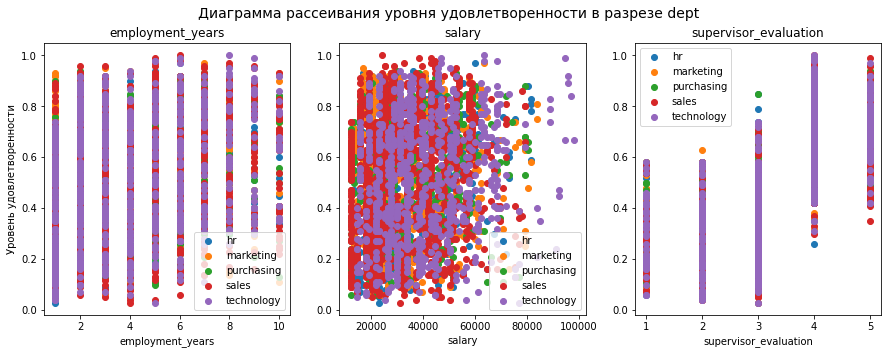

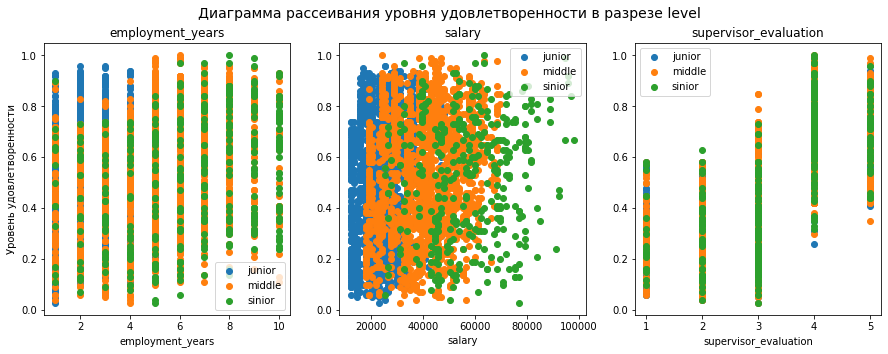

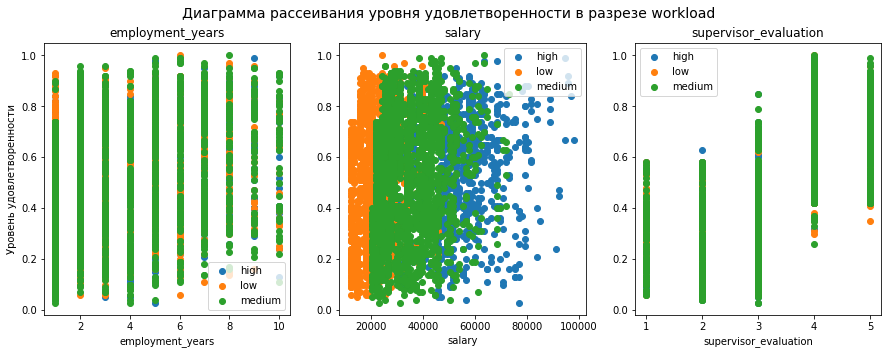

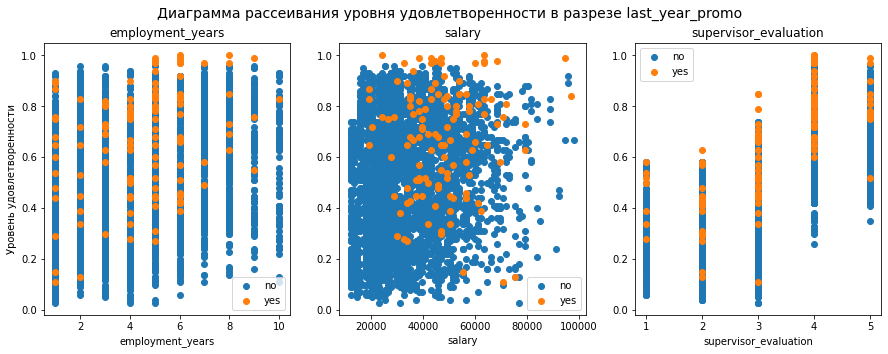

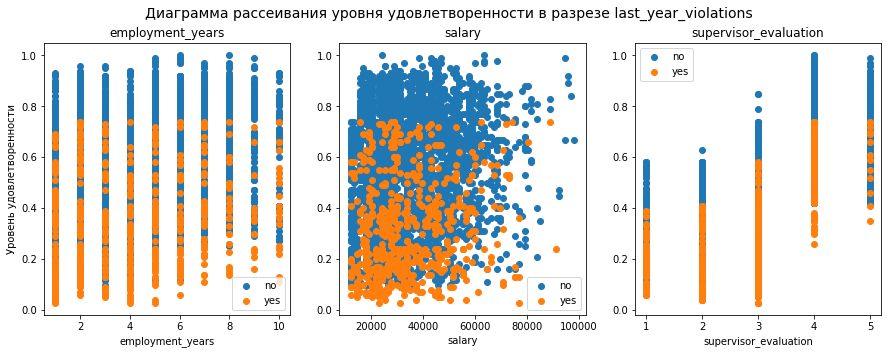

In [34]:
#выведем диаграммы рассеивания в цикле
for i in  train_rate.select_dtypes(exclude='number').columns.tolist():
    plt.figure(figsize=(15, 5))
    plt.subplots_adjust(hspace = 1.5)
    plt.subplot(1, 3, 1)
    scatter(i,'employment_years')
    plt.ylabel('Уровень удовлетворенности')
    plt.subplot(1, 3, 2)
    scatter(i,'salary')
    plt.subplot(1, 3, 3) 
    scatter(i,'supervisor_evaluation')
    plt.suptitle('Диаграмма рассеивания уровня удовлетворенности в разрезе '+i,fontsize=14)

Зависимость удовлетворенности от количественных признаков в разрезе категориальных признаков:
 - отдел:не выявлено,
 - уровень должности: в целом не выявлено, за исключеним того, что до 4-х лет наибольший уровень удовлетворенности (от 0.8 до 1) у джуниоров, на 5-й год - у мидлов,
 - уровень загрузки: не выявлено,
 - повышение за последний год: в целом если было повышение за последний год, то уровень удовлетворенности будет не ниже 0.25,
 - нарушение трудового договора: подтверждается наличие существенное корреляции - уровень удовлетворенности тех, кто имел нарушения, не выше 0.75

#### Подготовка признаков

По итогам проведенного анализа:
 - 1) пропуски:
   -  Отдел: заполним наиболее частым значением sales (38% всей выборки), не противоречит уровням з/плат. Поскольку данный признак имеет очень слабую корреляцию с целевым, то возможное некорректное заполнение 6 значений не критично.
   - Уровень должности: необходимо заполнить значение джун, что как раз является наиболее частым значением,
   - Уровень загрузки: 1 пропуск,соответствует среднему уровню загрузки- как раз является наиболее частым значением.
   
Т.о. стратегия для заполнения пропусков - заполнении наиболее частым значением.
 
 - 2)Исключение каких-либо признаков в модели:
   - Мултиколлинеарность признаков отсутствует - на этом основании ничего не исключаем,
   - Есть 3 признака с крайне низкой корреляцией, но при этом коэф-т не равен 0, поэтому исключать их также не будем
 
 
 - 3)Проверим на наличие дубликатов при удалении id из тренинговой выборки

#### Вывод по исследовательскому анализу

Распределение признаков в тестовой и тренинговой выборке в процетном соотношении очень похожи,данные в категориальных признаках несбалансированы, особенно это выражено в признаках повышение за последний год и нарушение трудового договора:
 - отдел: наиболее частое значение - sales(больше трети выборок), меньше всего - hr (11%),
 - уровень должности: наиболее частое значение - junior(47-48%), далее - middle (43-44%),меньше всего sinior(9%), распределение вполне ожидаемо и соответствует орг структуре многих крупных компаний,
 - уровень загрузки:наиболее частое - medium(52%), далее - low(30%), меньше всего - high (18%).
 - повышение за последний год: преимущественно нет (97%), да всего 3%.
 - нарушение трудового договора: преимущественно нет(86-87%), да всего 13-14%.
 
Распределение количественных признаков:
 - длительность работы: среднее значение 3.7 лет,медиана -3,минимальное значение -1, максимум - 10. Наиболее частое значение 1, далее чем выше срок, тем меньше кол-во сотрудников,75% - работают не более 6 лет, четверть от 6 до 10,
 - оценка руководителя: в среднем 3.5,медиана -4, минимум 1, максимум 5. Наиболее частое значение 4, далее 3, 1 ставится очень редко
 - уровень з/плат: среднее значение 33,9-34 тыс.,медиана -30 тыс.,минимальное - 12 тысяч, максимум немного отличается ( 98,4 и 96 тыс),наиболее частое значение - около 30 тысяч.
 - уровень удовлетворенности:тренинговая/тестовая выборки -  среднее 0.53/0.55,медиана -0.56/0.58,минимум - 0.03, максимум - 1.распределение нормальное с двумя пиками, наиболее частое значение - 0.65.
 
Корреляция признаков:
 - значение коэф-та Фи 0.9 и выше отсутствует, т.е. мультиколлинеарности нет,
 - С уровнем удовлетворенности наиболее коррелируют оценка качества работы руководителем (коэф-т 0.76),нарушения трудового договора(коэф-т 0.56) и длительность работы в компании(коэф-т 0.33), практически отсутствует корреляция с уровнем загрузки(коэф-т 0.06), отделом и уровнем должности(коэф-т 0.08). С уровнем з/платы и повышением за последний год корреляция слабая 


### Подготовка данных

Проверим, появятся ли дубликаты при удалении id 

In [35]:
train_rate.drop(['id'],axis=1).duplicated().sum()

245

При удалении id 245 строк из тренинговой выборки становятся дубликатами, что может исказить работу модели - удалим эти строки

Подготовим признаки в пайплайне, дополнив пайплайн шага предобработки. При кодировании категориальных признаков будем учитывать, что есть небинарные признаки с ранжированным значением (например, загрузка медиум выше, чем лоу и пр.)

In [36]:
#удалим дубликаты
train_rate = train_rate.drop(['id'],axis=1).drop_duplicates()

#выделим целевой признак и прочие
y_train = train_rate['job_satisfaction_rate']
X_train = train_rate.drop(['job_satisfaction_rate'], axis=1)

y_test = test['job_satisfaction_rate']
X_test = test.drop(['job_satisfaction_rate'], axis=1)

RANDOM_STATE = 42

X_train.head(1)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,sales,junior,medium,2,no,no,1,24000


In [37]:
# выделим количественные признаки, а также отдельно выделм категориальные для кодирования
ohe_columns = ['dept','last_year_promo','last_year_violations']
ord_columns = ['level','workload']
num_columns = ['employment_years','supervisor_evaluation','salary']

In [38]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'ohe_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
        #'ohe_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    ]
)


In [39]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и кодирование
ord_pipe = Pipeline(
    [
        (
            'ord_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior','middle','sinior'],
                    ['low','medium','high']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'ord_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [40]:
#предобработка данных
data_preprocessor = ColumnTransformer([
    ('ohe',ohe_pipe , ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', StandardScaler(), num_columns)
],
    remainder='passthrough')

### Обучение моделей

Обучим как минимум две модели. Возьмем одну линейную модель, а в качестве второй — дерево решений. Подберем гиперпараметры с помощью рандомайзера.
Выберем лучшую модель и проверим её качество на основе метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»):
 - Критерий успеха: SMAPE ≤ 15 на тестовой выборке.

In [41]:
# напишем ф-ю для SMAPE и инициируем ее через make_scorer с аргументом greater_is_better=False,
#тк чем ниже метрика, тем лучше
def smape(test,pred):
    return 100/ len (test) * np.sum (2 * np.abs (test-pred) / (np.abs (test) + np.abs (pred)))
smape_score = make_scorer(smape,greater_is_better=False)

In [42]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))        
])

# словарь для модели LinearRegression()
param_grid = {
         'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough'] 
    }


randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_score,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=50,
    error_score='raise'
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', randomized_search.best_score_)

y_pred = randomized_search.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {smape(y_test, y_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe_before',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                          

In [43]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))        
])

# словарь для модели DecisionTreeRegressor()
param_grid =  {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 20),
        'models__max_features': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough']  
    }

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_score,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=50,
    error_score='raise'
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', randomized_search.best_score_)

y_pred = randomized_search.predict(X_test)
print(f'Метрика SMAPE на тестовой выборке: {smape(y_test, y_pred)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe_before',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                          

Дерево решений показало лучшую метрику как при кросс-валидации, так и на тестовой выборке. Также на тестовой выборке  эта метрика не выше 15.
Оценим, какие признаки имеют наибольшее влияение

In [44]:
#инициируем лучшую модель
model = randomized_search.best_estimator_['models']

In [45]:
#предобработка данных 
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
X_test_preprocessed = preprocessor.transform(X_test)
X_train_preprocessed = preprocessor.transform(X_train)

#Получаем имена признаков для ohe, остальные можем использовать как есть
ohe_names = preprocessor.named_transformers_['ohe'].get_feature_names_out(input_features=ohe_columns)

# Объединяем все имена признаков в один список(количественные и орд передаем как есть)
names = np.concatenate([ohe_names, ord_columns, num_columns])

#завернем в датафрейм
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=names)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=names)

In [46]:
#создадим датафрейм с признаками и их влиянием и выведем их по убыванию значения
feature_importances = pd.DataFrame(
    {
        'Feature': names,
        'Importance': randomized_search.best_estimator_['models'].feature_importances_
    })
feature_importances.sort_values('Importance', ascending=False)

,Feature,Importance
9,supervisor_evaluation,0.66
10,salary,0.09
8,employment_years,0.07
5,last_year_violations_yes,0.05
6,level,0.05
7,workload,0.02
2,dept_sales,0.01
4,last_year_promo_yes,0.01
0,dept_marketing,0.01
3,dept_technology,0.01


### Вывод по лучшей модели

Исходя из метрики SMAPE (должна быть не более 15 на тестовой выборке), наилучшей моделью является дерево решений. Наиболее важные признаки для данной модели - оценка руководителя, далее с большим отрывом з/плата, кол-во лет работы в компании, нарушения за последний год и уровень должности. Крайне низкое значение имеют отдел,повышение за прошлый год и уровень загрузки.

## Задача: предсказание увольнения сотрудника из компании

Для этой задачи будем использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.

### Загрузка данных

In [47]:
#загрузим данные из файла с тренировочной выборкой
train_quit = download('train_quit')

#выведем первые 5 строк
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [48]:
#загрузим данные из файла с тренировочной выборкой
test_target_quit = download('test_target_quit')

#выведем первые 5 строк
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


На первый взгляд с данными все в порядке

### Предобработка данных

In [49]:
#выведем инфо по тренинговой выборке
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [50]:
#выведем инфо по целевому признаку
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Пропуски в обоих файлах отсутствуют, тип данных корректный.

Проверим совпадают ли сотрудники (id) в тестовой выборке и целевом признаке (одинаковых id должно быть 2000).Также проверим есть совпадения в id для тренинговой и тестовой выборках

In [51]:
id_replaced = list(set(test_target_quit['id'].unique()) & set(test['id'].unique()))

len(id_replaced)

2000

In [52]:
id_replaced = list(set(train_quit['id'].unique()) & set(test['id'].unique()))

id_replaced

[]

Сотрудники в тестовой выборке и целевом признаке полностью совпадают, в тестовой и тренинговой - совпадений нет.

Проведем проверку на явные и неявные дубликаты

In [53]:
#выведем кол-во явных дубликатов
train_quit.duplicated().sum()

0

In [54]:
#выведем кол-во дубликатов id
train_quit['id'].duplicated().sum()

0

Проверим тренинговую выборку на дубликаты без айди

In [55]:
train_quit.drop(['id'],axis=1).duplicated().sum()

1413

In [56]:
#выведем уникальные значение из тренировочного файла
for column in train_quit.select_dtypes(exclude='number'):
    print (column,':',train_quit.select_dtypes(exclude='number')[column].unique())

dept : ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level : ['middle' 'junior' 'sinior']
workload : ['high' 'medium' 'low']
last_year_promo : ['no' 'yes']
last_year_violations : ['no' 'yes']
quit : ['no' 'yes']


**Вывод по предобработке**:

 - явные дубликаты отсутствуют, как и неявные,
 - типы данных корректные, пропуски в тренинговой выборке отсутствуют,
 - перед обучением удалим строки, которые станут дубликатами после удаления id

### Исследовательский анализ данных

3.1. Проведем исследовательский анализ всех выборок

3.2. Составим портрет «уволившегося сотрудника».

3.3. Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируем и сравним распределение признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используем данные с обоими целевыми признаками тестовой выборки.

#### Исследовательский анализ всей тренинговой и тестовой выборок

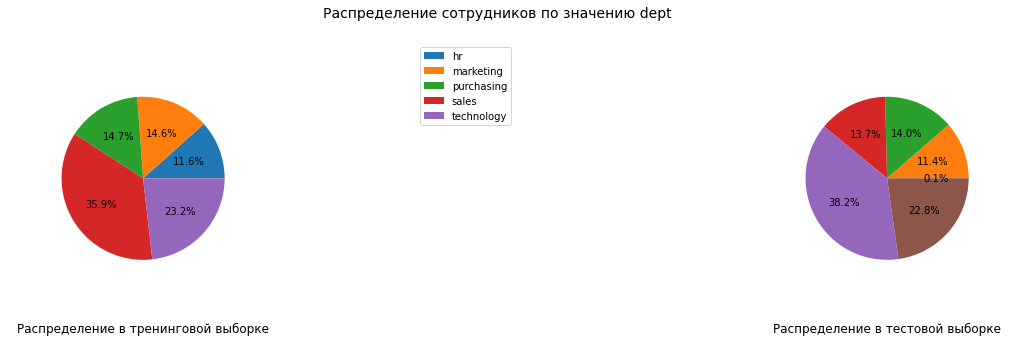

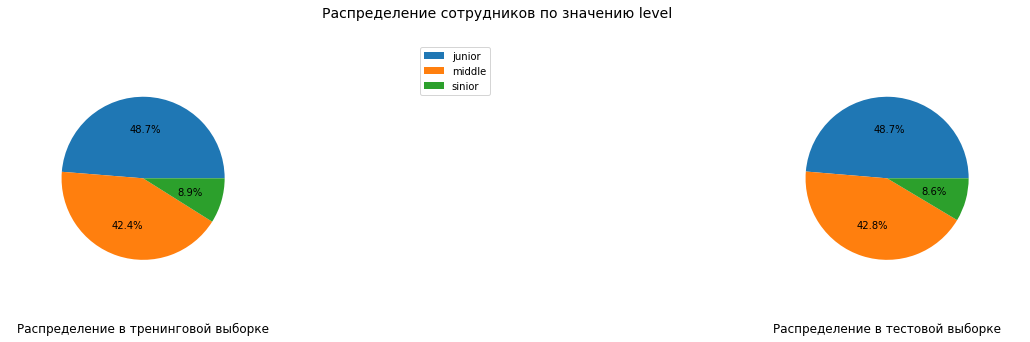

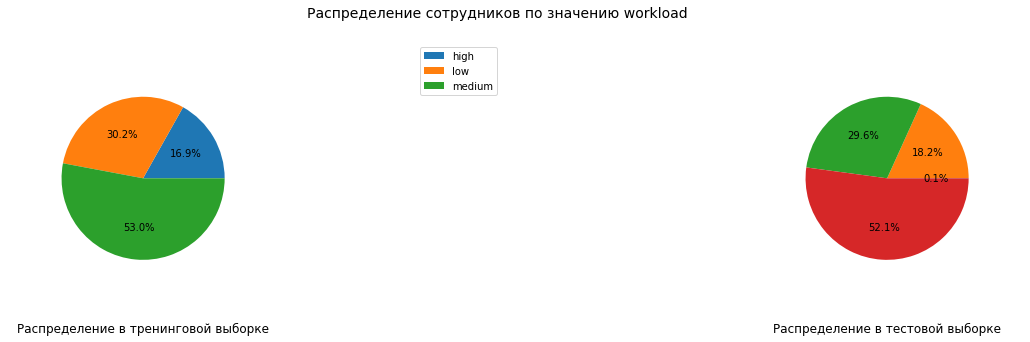

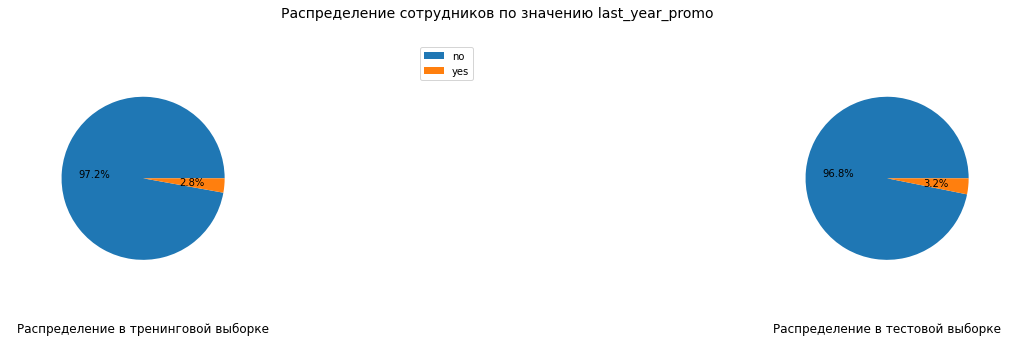

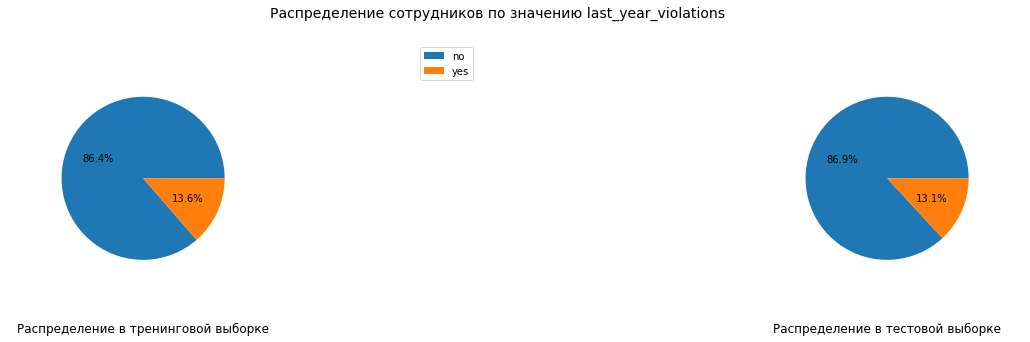

In [57]:
 #выведем 
for column in  train_quit.drop(['quit'],axis=1).select_dtypes(exclude='number').columns.tolist():
    pie_1(train_quit,test.dropna(axis=0),column)

Тестовая выборка та же, что и в первой задаче. Распределение категориальных признаков в новой тренинговой выборке практически такое же, как и в предыдущей, несущественное отличается процентовка в разрезе отделов.

Оценим распределение сотрудников по признаку увольнение.

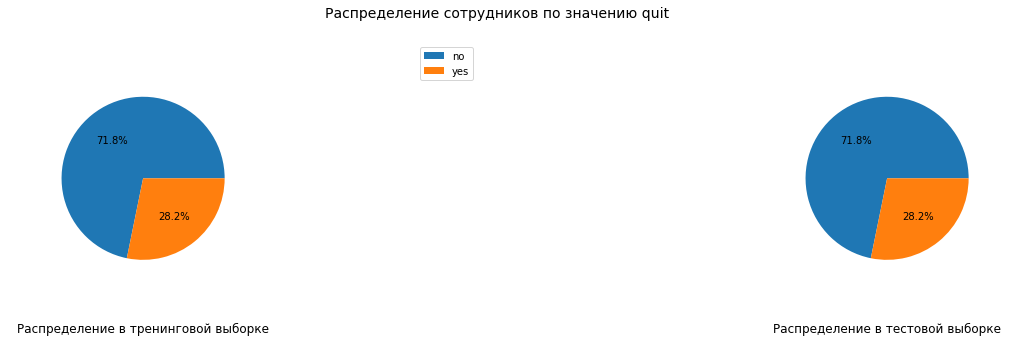

In [58]:
pie_1(train_quit,test_target_quit,'quit')

Распределение в выборках одинаковое: уволенные и нет - 28% к 72%.

Оценим статистику и распределение количественных признаков в новой тренинговой выборке ( в тестовой уже проводили в 1-й задаче)

In [59]:
train_quit.drop(['id'],axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
employment_years,"4,000.00",3.70,2.54,1.00,2.00,3.00,6.00,10.00
supervisor_evaluation,"4,000.00",3.47,1.00,1.00,3.00,4.00,4.00,5.00
salary,"4,000.00","33,805.80","15,152.42","12,000.00","22,800.00","30,000.00","43,200.00","96,000.00"


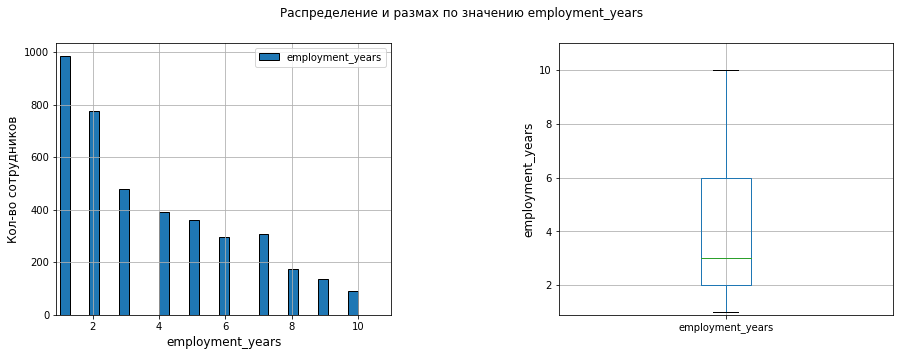

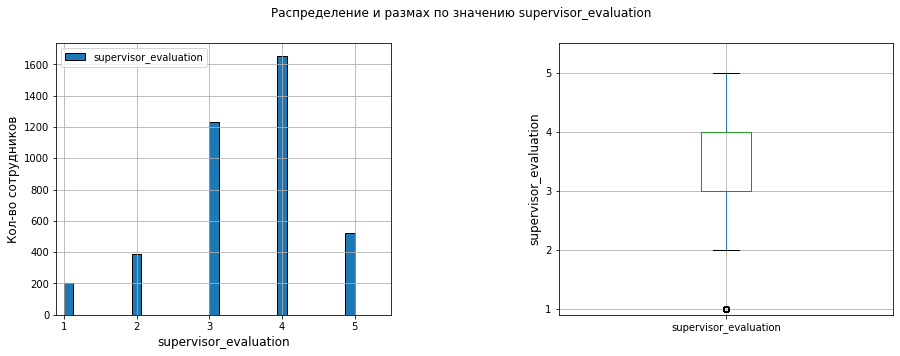

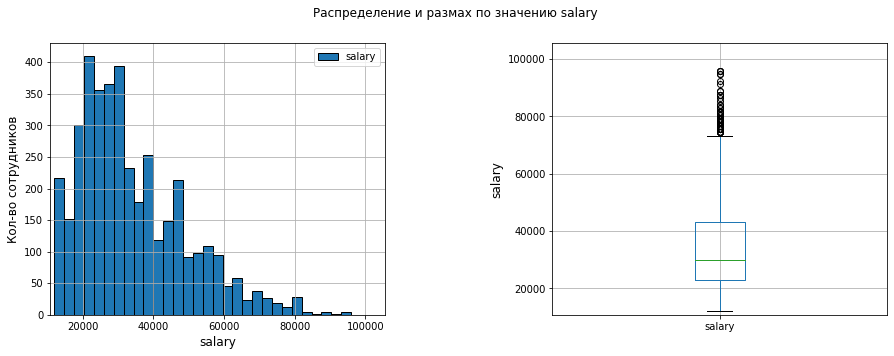

In [60]:
 #выведем гистограмму распределения и диаграмму размаха
for column in  train_quit.drop(['id'],axis=1).select_dtypes(include='number').columns.tolist():
    hist_box(train_quit.drop(['id'],axis=1).select_dtypes(include='number'),column)

Статистика и распределение в новой тренинговой выборке схоже с предыдущей.

Построим матрицу корреляции для оценик влияния признаков на целевой - увольнение

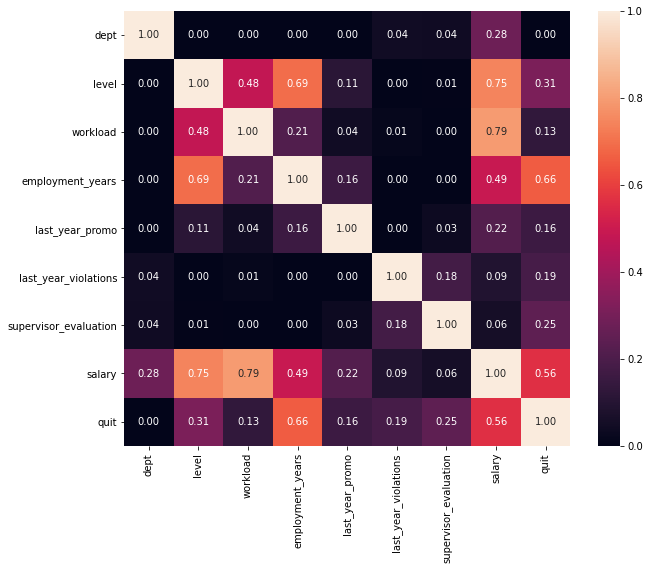

In [61]:
#построим матрицу корреляции
fig, ax = plt.subplots(figsize=(10, 8));
sns.heatmap(
    train_quit.drop(['id'],axis=1).phik_matrix(
    interval_cols =['employment_years','salary']
),
ax=ax, annot=True, fmt='.2f'
);

 - Мультиколлинеарность отсутствует.
 - Наибольшая корреляция признака увольнение прослеживается с кол-вом отработанных в компании лет и с з/платой (коэф-ты 0.66 и 0.56 соответственно), отсутствует корреляция с отделом.

#### Портрет  «уволившегося сотрудника»

Рассмотрим сначала в разрезе категориальных признаков,затем количественных

In [62]:
#создадим фукнцию для построения круговой диаграммы
def pie_2(df,column):
    df_1 =df.pivot_table(index=column,values='id',aggfunc='count').reset_index()
    df_2 =df.query('quit=="yes"').pivot_table(index=column,values='id',aggfunc='count').reset_index()
    
    fig, ax = plt.subplots(figsize = (20, 5))
    
    ax = plt.subplot(1, 2, 1)
    plt.pie(df_1['id'], autopct='%.1f%%', radius=0.75);
    plt.xlabel('Распределение всех сотрудников тренинговой выборке', fontsize=12);
    plt.legend(labels=df_1[column],loc='upper left', bbox_to_anchor=(1.5, 1.0));

    ax = plt.subplot(1, 2, 2)
    plt.pie(df_2['id'],autopct='%.1f%%', radius=0.75);
    
    plt.xlabel('Распределение уволенных сотрудников в тренинговой выборке', fontsize=12);
    #plt.legend(labels = df_2[column],loc='upper left', bbox_to_anchor=(1.0, 1.0));
    
    fig.suptitle('Распределение сотрудников по значению '+column,fontsize=14)
    plt.subplots_adjust(wspace=1,hspace = 1)
    plt.show()

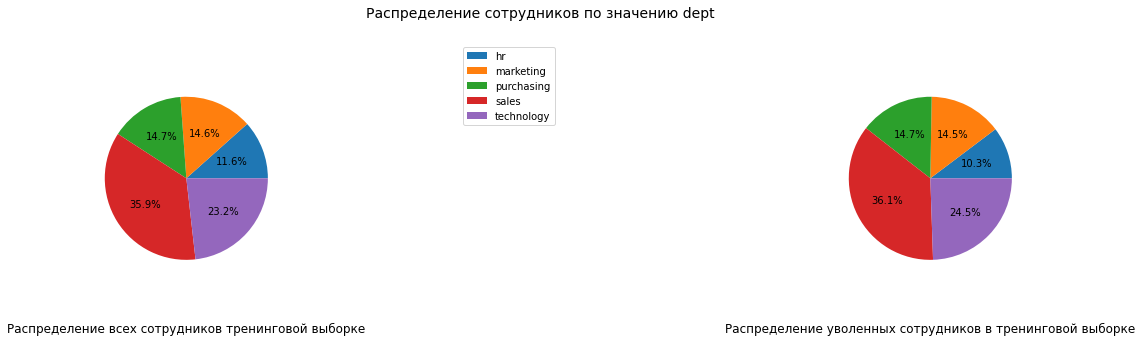

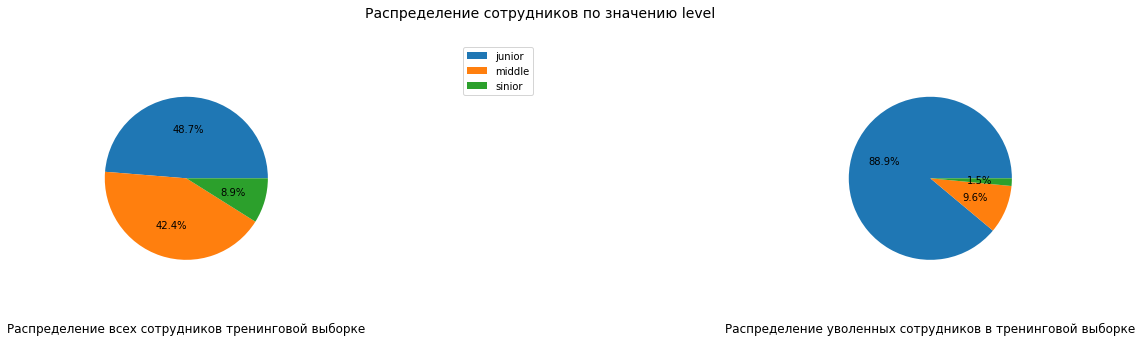

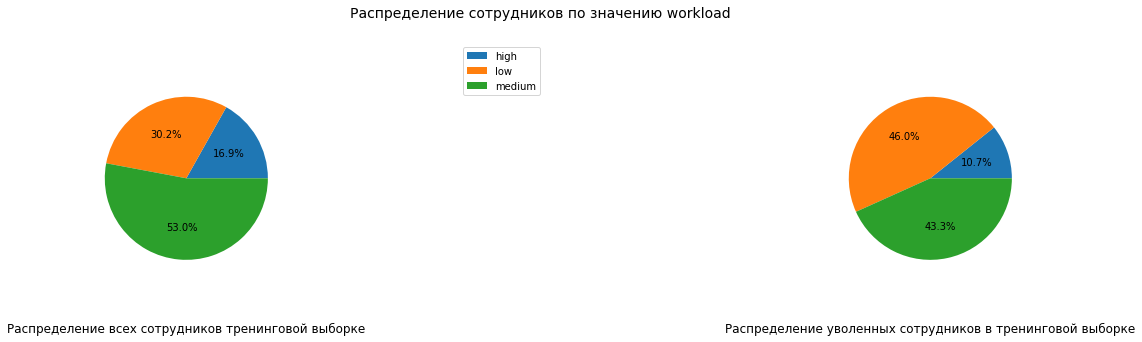

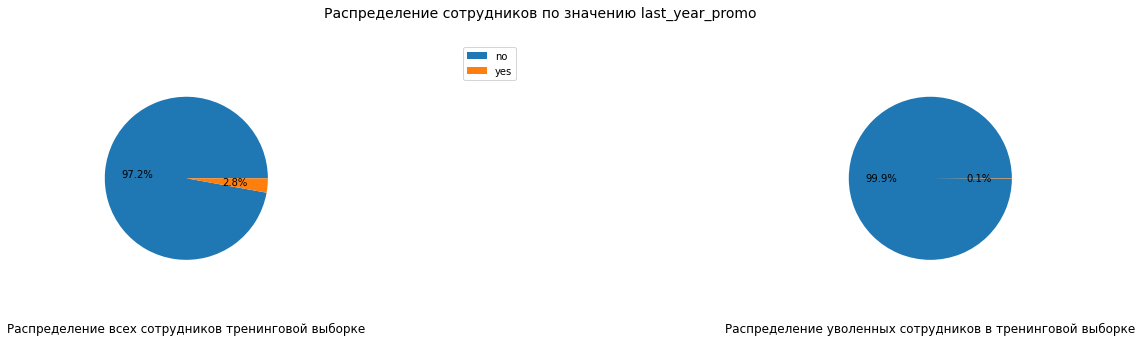

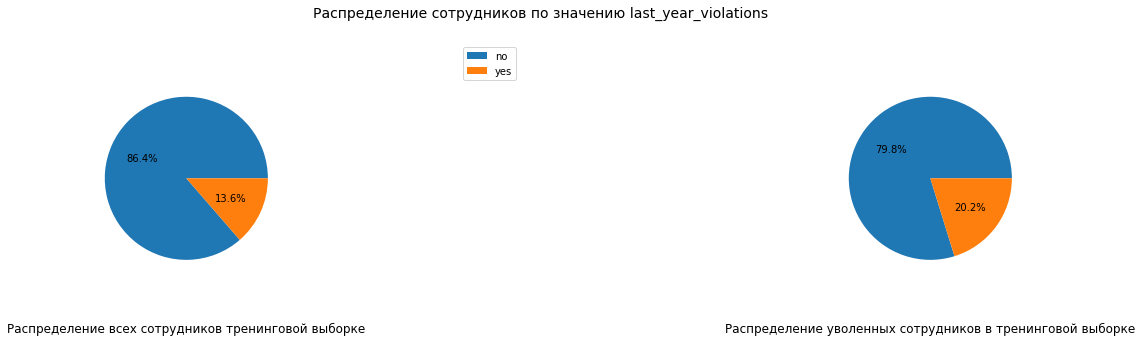

In [63]:
#выведем распределение категориальных признаков в разрезе уволенных сотрудников
for column in  train_quit.drop(['quit'],axis=1).select_dtypes(exclude='number').columns.tolist():
    pie_2(train_quit,column)

 Для уволенных сотрудников распределение признаков в тренинговой выборке по сравнению с общим распределением:
 - отдел: распределение такое же, как и для всех сотрудников
 - уровень должности: джунов почти в 2 раза больше, в то время как мидлов меньше в 4 раза,доля сеньор меньше почти в 6 раз по сравнению с общим распределением,
 - уровень загрузки: чаще увольняются с низким уровнем, далее чуть меньше со средним, реже всего с высоким,
 - повышение за последний год: практически отсутствуют повышенные за последний год.
 - нарушение трудового договора: доля нарушивших трудовой договор выше, чем в общей выборке - 20%

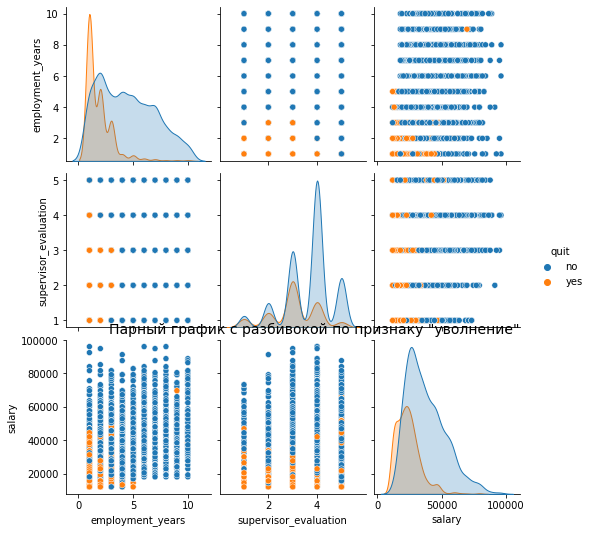

In [64]:
#выведем матрицу парных графиков для количественных признаков с подсветкой признака увольнение
sns.pairplot(train_quit.drop(['id'],axis=1),hue = 'quit')
plt.title('Парный график с разбивокой по признаку "уволнение"', fontsize=14,loc='right')
plt.show()

 - кол-во отработанных в компании лет: чем выше значение, тем меньше доля уволенных,
 - оценка руководителя: уволенные имеют любые оценки, при этом для уволенных наиболее частое значение - 3, в то время как у неуволенных - 4.
 - чем выше з/плата, тем меньше уволенных: при з/плате свыше 50 тыс значение уволенных минимально.
 
 Построим также диаграмму размаха для уволенных и нет сотрудников для количественных признаков

In [65]:
#создадим фукнцию для построения диаграммы размаха в разрезе признака увольнение
def boxplot (data,column):
    data.boxplot(column, by='quit', figsize=(5,5))
    plt.ylabel(column, fontsize=12);
    plt.xlabel(' ', fontsize=12);
    plt.title('Диаграмма размаха по значению '+column);

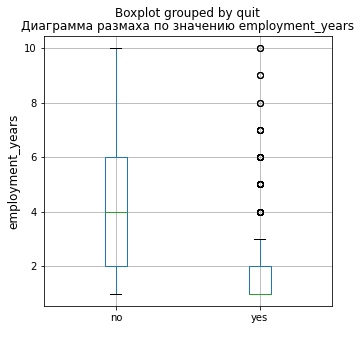

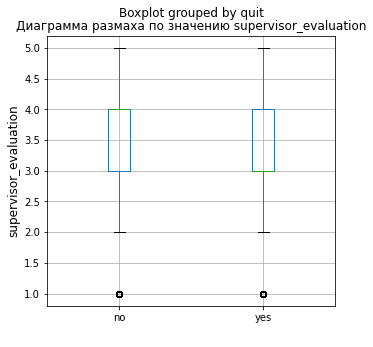

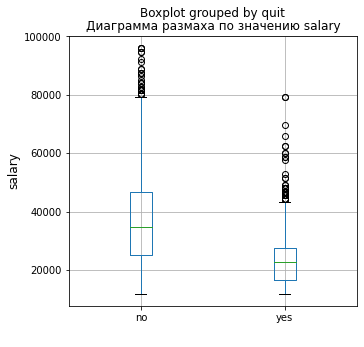

In [66]:
#выведем  диаграмму размаха
for column in  train_quit.drop(['id'],axis=1).select_dtypes(include='number').columns.tolist():
    boxplot(train_quit,column)

Диаграмма распределения подтверждает сделанные по парным графикам распределения выводы:
- кол-во отработанных в компании лет: уволенные имели кол-во отработанных лет во всем возможном диапазоне, но преимущественно этот срок не превышает 3 года,
- оценка руководителя: наиболее частое значение для уволенных сотрудников 3, для неуволенных - 4
- з/плата: уволенные сотрудники преимущественно имеют з/плату не выше 50 тыс, медианное значение з/платы ( порядка 22 тыс.) также ниже неуволенных (прорядка 27 тыс).

**Портрет «уволившегося сотрудника»**:

Это сотрудник с:
 - уровнем должности преимущественно джун,
 - с низким или средним уровнем загрузки, 
 - которого не повышали за последний год, 
 - его срок работы в компании не более 3 лет, 
 - оценка руководителя: наиболее частое значение 3,
 - з/плата: не выше 50 тыс.

#### Взаимосвязь удовлетворенности и увольнения

Оценим наличие взаимосвязи уровня удовлетворенности и уволнения через тестовую выборку, поскольку в новой тренинговой эти данные отсутствуют. Сначала построим матрицу корреляции для тестовой выборки

In [67]:
#объединим входные и целевой признак тестовой выборки
test = test.merge(test_target_quit,on='id',how='inner')

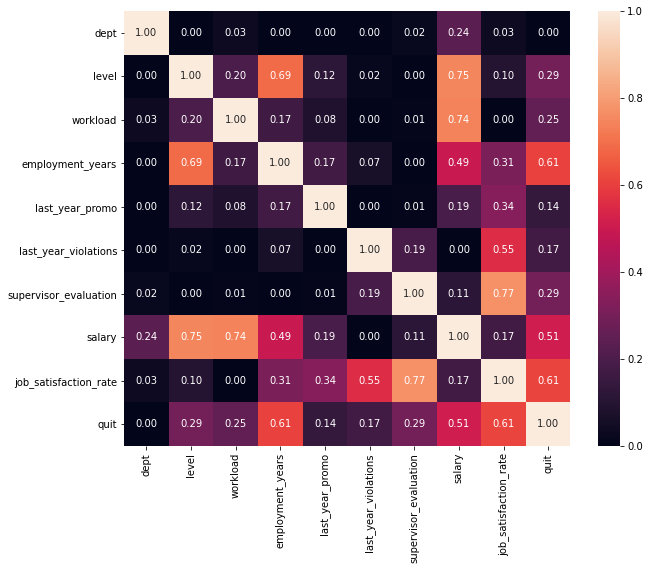

In [68]:
#построим матрицу корреляции
fig, ax = plt.subplots(figsize=(10, 8));
sns.heatmap(
    test.drop(['id'],axis=1).phik_matrix(
    interval_cols =['employment_years','salary', 'job_satisfaction_rate']
),
ax=ax, annot=True, fmt='.2f'
);

Мы видим, что наряду с кол-вом отработанных лет, корреляция признака увольнение и уровня удовлетворенности самая высокая- коэф-т - 0.61. Уровень удовлетворенности явно влияет на то, уволится сотрудник или нет.

Также обратим внимание, что корреляция увольнения и отдела равна 0 - стоит данный признак из входных удалить.

Построим диаграмму распределения признака

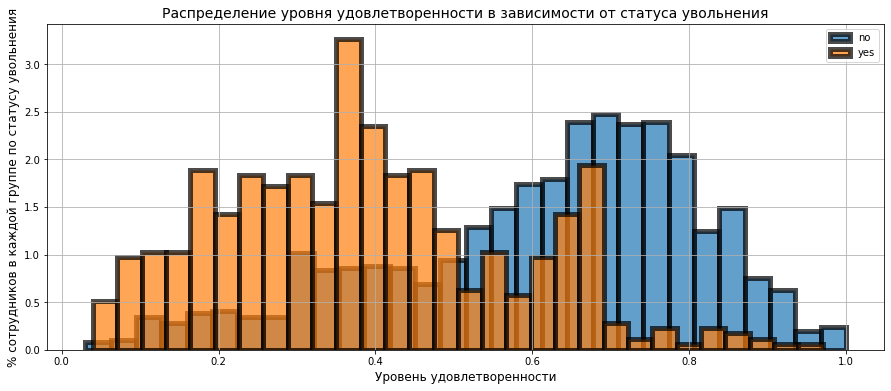

In [69]:
#создадим список значений признака
a=['no','yes']

#создадим функцию для построения графика распределения 
def hist(data, label):
    data.hist(label=label,linewidth=5, alpha=0.7,ec='black',bins = 30, grid = True,figsize=(15,6),density = True)

#создадим цикл для построения графика для значения из списка а
for i in a:
    hist(test.query('quit==@i')['job_satisfaction_rate'],label=i)

plt.legend()
plt.grid(True)
plt.ylabel('% сотрудников в каждой группе по статусу увольнения', fontsize=12)
plt.xlabel('Уровень удовлетворенности', fontsize=12)
plt.title('Распределение уровня удовлетворенности в зависимости от статуса увольнения', fontsize=14)
plt.show()

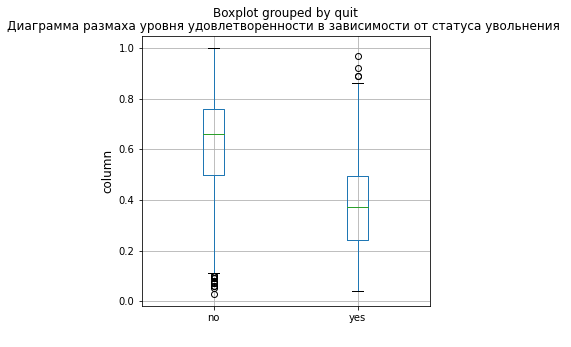

In [70]:
test.boxplot('job_satisfaction_rate', by='quit', figsize=(5,5))
plt.ylabel('column', fontsize=12);
plt.xlabel(' ', fontsize=12);
plt.title('Диаграмма размаха уровня удовлетворенности в зависимости от статуса увольнения ');

 - По диаграмме распределения: значение уровня удовлетворенности для уволенных сотрудников чаще всего не превышает значения 0.7, до значения удовлетворенности 0.5 преобладает доля уволенных сотрудников.
 - По боксплоту: 75% уволенных сотрудников имеют уровень удовлетворенности не выше 0.5, в то время как 75% неуволенных - свыше 0.5.

Т.о. удовлетворенность однозначно влияет на то, уволится сотрудник или нет.

#### Вывод по исследовательскому анализу

 - Тестовая выборка та же, что и в первой задаче. Распределение признаков в новой тренинговой выборке практически такое же, как и в предыдущей, несущественное отличается процентовка в разрезе отделов.
 - Распределение по признаку увольнение: да и нет - 28% к 72%.
 - Мультиколлинеарность отсутствует.
 - Наибольшая корреляция признака увольнение прослеживается с кол-вом отработанных в компании лет,уровнем удовлетворенности и с з/платой (коэф-ты 0.66 и 0.56 соответственно), отсутствует корреляция с отделом. Уровень удовлетворенности явно влияет на то, уволится сотрудник или нет. Также обратим внимание, что корреляция увольнения и отдела равна 0 - стоит данный признак из входных удалить.
 - Портрет «уволившегося сотрудника», это сотрудник с:
   - уровнем должности преимущественно джун,
   - с низким или средним уровнем загрузки,
   - которого не повышали за последний год,
   - его срок работы в компании не более 3 лет,
   - оценка руководителя: наиболее частое значение 3,
   - з/плата: не выше 50 тыс. 

### Добавление нового входного признака

Мы выявили, что job_satisfaction_rate и quit существенно коррелируют. Добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи (сначала для тренинговой выборки, затем для тестовой)

In [71]:
#предскажем значение признака удовлетворенности для новой тренинговой выборки
y_pred_train = randomized_search.predict(train_quit.drop(['id','quit'],axis=1))
#объединим предсказание сначала с id тренинговой выборки, чтобы можно было объединит с самой трениговой выборкой 
job_satisfaction_rate = pd.DataFrame(zip(train_quit['id'],y_pred_train), columns = ['id','job_satisfaction_rate'])
#объединим предсказанный уровень удовлетворенности с тренинговой выборкой
train_quit_rate = train_quit.merge(job_satisfaction_rate,on='id',how='inner')
#выведем новую таблицу
train_quit_rate.sample(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
2983,983224,sales,junior,low,1,no,no,5,19200,no,0.71
792,121914,technology,middle,medium,7,no,no,5,40800,no,0.69
2368,623401,sales,junior,medium,5,no,yes,3,27600,no,0.40
3742,522780,hr,middle,high,7,no,no,5,62400,no,0.82
2957,506772,sales,junior,low,2,no,no,4,12000,yes,0.64


In [72]:
#предскажем значение признака удовлетворенности для новой тренинговой выборки
y_pred_test = randomized_search.predict(test.drop(['id','quit','job_satisfaction_rate'],axis=1))
#преобразуем предсказания в датафрейм 
job_satisfaction_rate = pd.DataFrame(y_pred_test, columns = ['job_satisfaction_rate'])
#заменим столбец с уровнем удовлетворенности предсканными моделью из 1-й задачи значениями
test['job_satisfaction_rate'] = job_satisfaction_rate
#выведем новую таблицу
test.sample(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
1512,288080,marketing,middle,high,6,no,yes,4,57600,0.61,no
811,275269,purchasing,junior,high,1,no,no,4,38400,0.57,yes
937,635126,sales,middle,medium,5,no,no,4,33600,0.67,no
1838,425164,sales,middle,low,9,no,no,5,30000,0.79,no
144,194495,marketing,middle,medium,5,no,yes,3,40800,0.22,no


### Подготовка данных и обучение модели

Подготовим данные для предсказания того, уволится сотрудник или нет.
Подготовим 2 набора входных признаков и их обработку:
 - Сначала обучим модели на всех входных признаках, 
 - Затем удалим из входных признаков отдел.

Обучать модель будем сначала на 1-м, потом на 2-м наборе данных.Оценим эффект через изменение метрики при этом.

Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке.

Помним, что при удалении id появятся дубликаты, которые могут исказить обучение модели, - удалим их

In [73]:
train_quit_rate = train_quit_rate.drop(['id'],axis=1).drop_duplicates()
train_quit_rate.shape

(2587, 10)

Сначала обучим модели со всеми входными признаками

In [74]:
#выделим целевой признак и прочие
y_train = train_quit_rate['quit'].apply(lambda x: 1 if x=='yes' else 0)
X_train = train_quit_rate.drop(['quit'], axis=1)

y_test = test['quit'].apply(lambda x: 1 if x=='yes' else 0)
X_test = test.drop(['quit'], axis=1)

RANDOM_STATE = 42

#создадим столбцы с признаками категор и количественными, отдельно выделим катеориальные для ранжирования
ohe_columns_1 = ['dept','last_year_promo','last_year_violations']
ord_columns_1 = ['level','workload']
num_columns_1 = ['employment_years','supervisor_evaluation','salary','job_satisfaction_rate']

# сводим подготовку данных ohe_pipe и ord_pipe те же, что у 1-й задачи, не будем дублировать
data_preprocessor_1 = ColumnTransformer([
    ('ohe',ohe_pipe , ohe_columns_1),
    ('ord', ord_pipe, ord_columns_1),
    ('num', StandardScaler(), num_columns_1)
],
    remainder='passthrough')

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_1 = Pipeline([
    ('preprocessor', data_preprocessor_1),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))        
])

In [75]:
# зададим гиперпараметры моделей
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough']  
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 50),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough'] 
    },

    # словарь для модели LogisticRegression()
    {
         'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': [0.01,0.1,1,10,100], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough'] 
    },
     # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE,probability=True)],
        'models__kernel': ['linear', 'rbf','poly','sigmoid'],   
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),RobustScaler(), 'passthrough'] 
    }
]

In [76]:
#произведем поиск лучше модели рандомайзером
randomized_search_1 = RandomizedSearchCV(
    pipe_final_1, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=50,
    error_score='raise'
)
randomized_search_1.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_1.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', randomized_search_1.best_score_)

y_pred = randomized_search_1.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred[:,1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe_before',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                          

Лучшая модель - к-ближайших соседей с к=47, значение ROC-AUC  при кросс-валидации 90.7% тестовой выборке 91.2% - соответствует необходимой.

При корреляционном анализе мы выявили, что корреляция целевого признака и отдела отсутствует. Обучим модель без данного признака и оценим значение метрики

In [77]:
#выделим целевой признак и прочие
y_train = train_quit_rate['quit'].apply(lambda x: 1 if x=='yes' else 0)
X_train = train_quit_rate.drop(['quit','dept'], axis=1)

y_test = test['quit'].apply(lambda x: 1 if x=='yes' else 0)
X_test = test.drop(['quit','dept'], axis=1)

RANDOM_STATE = 42

#создадим столбцы с признаками категор и количественными, отдельно выделим катеориальные для ранжирования
ohe_columns_2 = ['last_year_promo','last_year_violations']
ord_columns_2 = ['level','workload']
num_columns_2 = ['employment_years','supervisor_evaluation','salary','job_satisfaction_rate']

# сводим подготовку данных ohe_pipe и ord_pipe те же, что у 1-й задачи, не будем дублировать
data_preprocessor_2 = ColumnTransformer([
    ('ohe',ohe_pipe , ohe_columns_2),
    ('ord', ord_pipe, ord_columns_2),
    ('num', StandardScaler(), num_columns_2)
],
    remainder='passthrough')

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))        
])

In [78]:
randomized_search_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=50,
    error_score='raise'
)
randomized_search_2.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', randomized_search_2.best_score_)

y_pred = randomized_search_2.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred[:,1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe_before',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  

Без признака "отдел" значение метрики стало чуть выше как при кросс-валидации, так и на тестовой выборке

Оценим важность признаков для лучшей модели

In [79]:
#предобработка данных 
preprocessor = randomized_search_2.best_estimator_.named_steps['preprocessor']
X_test_preprocessed = preprocessor.transform(X_test)

#Получаем имена признаков для ohe, остальные можем использовать как есть
ohe_names = preprocessor.named_transformers_['ohe'].get_feature_names_out(input_features=ohe_columns_2)

# Объединяем все имена признаков в один список(количественные и орд передаем как есть)
names = np.concatenate([ohe_names, ord_columns_2, num_columns_2])

#проверим все ли признаки переданы и в каком виде
names

array(['last_year_promo_yes', 'last_year_violations_yes', 'level',
       'workload', 'employment_years', 'supervisor_evaluation', 'salary',
       'job_satisfaction_rate'], dtype=object)

  0%|          | 0/100 [00:00<?, ?it/s]

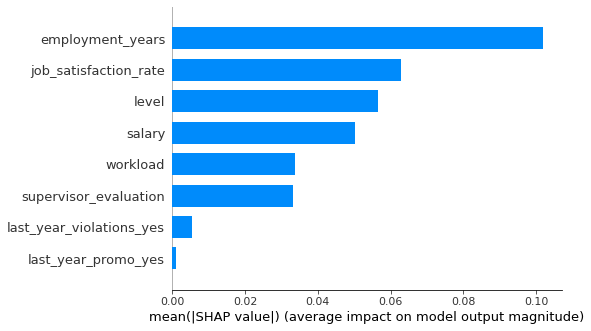

In [80]:
#создадим из предобработанных тестовых данных датафрейм
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=names)

#построим график важности с помощью метода SHAP, 
#тестовые признаки для ускорения обработки сократим сэмплом - выбираются любые 100 значений
explainer = shap.KernelExplainer(
    randomized_search_2.best_estimator_['models'].predict_proba,\
    shap.sample(X_test_preprocessed,100,random_state=RANDOM_STATE)
)
shap_values = explainer(shap.sample(X_test_preprocessed,100,random_state=RANDOM_STATE))

shap.summary_plot(shap_values[:,:,1],plot_type='bar',max_display=17)

Наиболее важным признаком является кол-во отработанных в компании лет, далее идет уровень занимаемой должности и уровень удовлетворенности, з/плата, уровень загруженности и оценка руководителем. Нарушение трудового договора и повышение за прошлый год являются несущественными признаками для модели.

Оценим вклад признаков в классификацию каждого наблюдения

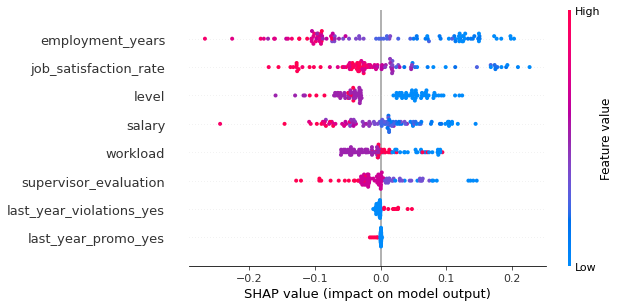

In [81]:
shap.plots.beeswarm(shap_values[:,:,1])

Чем выше величина признаков кол-во отработанных в компании лет,чем выше уровень должности (судя по цветам и ранжированию признака это мидл и синьор),чем выше уровень удовлетворенности, чем выше з/плата, чем выше оценка руквоводителя, если загрузка средняя (значение цвета посередине, как и средняя загрузка при ранжировании признака кодировщиком),тем выше вероятность отнесения объектов к классу 0, т.е. тем ниже вероятность уволнения сотрудника.Также если было повышение за прошлый год, то модель скорее отнесет значение к классу 0. Если же были нарушения трудового договора, то модель скорее отнесет к классу 1,т.е.к высокой вероятности увольнения.

Попробуем оценить модель при исключении признаков нарушение трудового договора и повышение за прошлый год как несущественных признаков.

In [82]:
#выделим целевой признак и прочие
y_train = train_quit_rate['quit'].apply(lambda x: 1 if x=='yes' else 0)
X_train = train_quit_rate.drop(['quit','dept','last_year_promo','last_year_violations'], axis=1)

y_test = test['quit'].apply(lambda x: 1 if x=='yes' else 0)
X_test = test.drop(['quit','dept','last_year_promo','last_year_violations'], axis=1)

RANDOM_STATE = 42

X_train.head(1)

,level,workload,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
0,middle,high,2,4,54000,0.66


In [83]:
ord_columns_3 = ['level','workload']
num_columns_3 = ['employment_years','supervisor_evaluation','salary','job_satisfaction_rate']

data_preprocessor_3 = ColumnTransformer([
    ('ord', ord_pipe, ord_columns_3),
    ('num', StandardScaler(), num_columns_3)
],
    remainder='passthrough')

In [84]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_3 = Pipeline([
    ('preprocessor', data_preprocessor_3),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))        
])

randomized_search_3 = RandomizedSearchCV(
    pipe_final_3, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=50,
    error_score='raise'
)
randomized_search_3.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search_3.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', randomized_search_3.best_score_)

y_pred = randomized_search_3.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred[:,1])}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord_before',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                                               'medium',
                               

Метрика стала на 0.46% выше при кросс-валидации и на 0.02% выше на тестовой выборке при исключении кроме отдела признаков нарушение трудового договора и повышение за предыдущий год. Снова оценим вклад признаков с новым перечнем входных признаков

  0%|          | 0/100 [00:00<?, ?it/s]

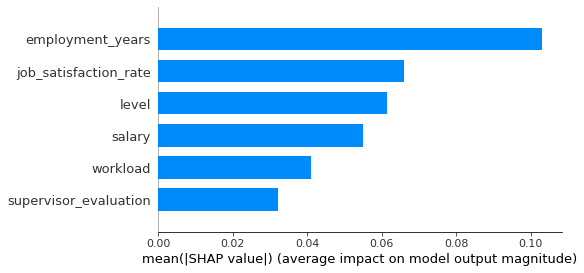

In [85]:
#предобработка данных 
preprocessor = randomized_search_3.best_estimator_.named_steps['preprocessor']
X_test_preprocessed = preprocessor.transform(X_test)


# Объединяем все имена признаков в один список(количественные и орд передаем как есть)
names = np.concatenate([ord_columns_3, num_columns_2])

#создадим из предобработанных тестовых данных датафрейм
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=names)

#построим график важности с помощью метода SHAP, 
#тестовые признаки для ускорения обработки сократим сэмплом - выбираются любые 100 значений
explainer = shap.KernelExplainer(
    randomized_search_3.best_estimator_['models'].predict_proba,\
    shap.sample(X_test_preprocessed,100,random_state=RANDOM_STATE)
)
shap_values = explainer(shap.sample(X_test_preprocessed,100,random_state=RANDOM_STATE))

shap.summary_plot(shap_values[:,:,1],plot_type='bar',max_display=17)

Ранжирование признаков после удаления двух несущественных не изменилось

### Вывод по лучшей модели

Лучшая модель для 2-й задачи, определенная путем рандомного перебора из 4-х моделей (Дерево решений, Логрегрессия,метод векторов и метод к-ближайших соседей) с рядом гиперпарамтеров, - это метод к-ближайших соседей с к=47. Лучшая модель опрелена на основании метрики ROC-AUC, которая показала наиболее высокое значение при кросс-валидации - 91.6, на тестовой выборке значение метрики 91.9%. Входными признаками для данной модели являются (в порядке снижения важности): кол-во отработанных в компании лет,уровень удовлетворенности, уровень занимаемой должности, з/плата, уровень загрузки и оценка руководителем

## Общий вывод

В рамках проекта было поставлено и реализовано 2 задачи:
 - Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
 - Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании. 

Данные задачи направлены на оптимизацию управления персоналом: удовлетворённость работой напрямую влияет на отток сотрудников,а предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник. 

Данные для работы были представлены 5-ю таблицами: 2 тренинговые выборки, одна тестовая и 2 таблицы с целевыми признаками тестовой выборки для каждой  задачи. Признаки в данных таблицах: 
 - уникальный идентификатор сотрудника;
 - отдел, в котором работает сотрудник;
 - уровень занимаемой должности;
 - уровень загруженности сотрудника;
 - длительность работы в компании (в годах);
 - показывает, было ли повышение за последний год;
 - показывает, нарушал ли сотрудник трудовой договор за последний год;
 - оценка качества работы сотрудника, которую дал руководитель;
 - ежемесячная зарплата сотрудника;
 - уровень удовлетворённости сотрудника работой в компании, целевой признак (от 0 до 1)
 - признак увольнения сотрудника,целевой признак.

В рамках предобработки выявлено, что явные  дубликаты отсутствуют, обработаны неявные дубликаты (пробелы), данные представлены в корректном типе. Есть несущественные пропуски в данных с отделом, уровнем должности и загрузки:согласно проведенного анализа было выявлено, что их заполнение возможно наиболее частым значением соответствующего признака из выборки, что и было осуществлено в пайплайне.

В рамках исследовательского анализа выявлено, что:
  - данные в категориальных признаках несбалансированы, особенно это выражено в признаках повышение за последний год и нарушение трудового договора,
  - наиболее частый отдел (более 1/3) - это отдел продаж, по уровню должности примерно одинаково джуниоров и мидлов , намного меньше синьоров (что неудивительно), загрузка чаще всего средняя (более 50%), доля повышенных за последний год сотрудников - около 3%, доля сотрудников с нарушениями трудового договора - 13-14%.
  - длительность работы: наиболее частое значение 1, далее чем выше срок, тем меньше кол-во сотрудников,75% - работают не более 6 лет,  четверть от 6 до 10,
  - оценка руководителем: наиболее частое значение 4, далее 3, 1 ставится очень редко,
  - уровень з/плат: наиболее частое значение - около 30 тысяч,все з/платы в интервале от 12000 до 98400
  - уровень удовлетворенности: распределение нормальное с двумя пиками, наиболее частое значение - 0.65.
  - распределение "уволенных": да и нет - 28% к 72%.
  - Портрет «уволившегося сотрудника»:
    - уровень должности преимущественно джун,
    - низкий или средний уровень загрузки,
    - которого не повышали за последний год,
    - его срок работы в компании не более 3 лет,
    - оценка руководителя: наиболее частое значение 3,
    - з/плата: не выше 50 тыс.  
  
Для построения модели для каждой задачи осуществлено следующее: 
- Первая задача:
  - Проведен корреляционный анализ признаков: согласно коэф-та Фи, с уровнем удовлетворенности наиболее коррелируют оценка качества работы руководителем (коэф-т 0.76),нарушения трудового договора(коэф-т 0.56) и длительность работы в компании(коэф-т 0.33), практически отсутствует корреляция с уровнем загрузки(коэф-т 0.06), отделом и уровнем должности(коэф-т 0.08). С уровнем з/платы и повышением за последний год корреляция слабая.
  - Подготовлены признаки, с помощью пайплана было автоматизировано обучено 2 модели (LinearRegression,DecisionTreeRegressor) с разными гиперпараметрами, из которых была выбрана лучшая путем поиска наилучшего значения  метрики SMAPE («симметричное среднее абсолютное процентное отклонение»,должна быть не более 15 на тестовой выборке): наилучшей моделью является дерево решений, метрика на тестовой выборке 14.4. Наиболее важные признаки для данной модели - оценка руководителя, далее с большим отрывом з/плата, кол-во лет работы в компании, нарушения за последний год и уровень должности. Крайне низкое значение имеют отдел и уровень загрузки.
- Вторая задача:
  - Проведен корреляционный анализ признаков: наибольшая корреляция признака увольнение прослеживается с кол-вом отработанных в компании лет и уровнем удовлетворенности (коэф-т 0.66)и з/платой (коэф-т 0.56), отсутствует корреляция с отделом.
  - Подготовлены признаки, с помощью пайплана было автоматизировано обучено 4 модели (KNeighborsClassifier,DecisionTreeClassifier, LogisticRegression,SVC) с разными гиперпараметрами, из которых была выбрана лучшая путем поиска наилучшего значения  метрики ROC-AUC: метод к-ближайших соседей с к=47. Наиболее высокое значение метрики на тестовой выборке - 92.5%. Входными признаками для данной модели являются (в порядке снижения важности): кол-во отработанных в компании лет,уровень удовлетворенности, уровень занимаемой должности, з/плата, уровень загрузки и оценка руководителем. 
  - Наилучшую метрику модель показала при исключении признаков отдел ( в связи с отсутствием корреляции на основании коэф-та Фи) и признаков нарушение трудового договора и повышение за прошлый год (исключение 2-х последних признаков было осуществлено на основании проведенного анализа важности признаков методом SHAP). 
  
На основании проведенного анализа и построения моделей прогнозирования уровня удовлетворенности и увольнения сотрудников считаем необходимым предложить следующее:
 - в первую очередь, инициировать мероприятия, способствующие поднятию уровня удовлетворенности сотрудников, которые подходят под вышеуказанный портрет «уволившегося сотрудника»:
   - по итогам проведенной оценки руководителя давать сотруднику развивающую обратную связь, которая будет мотивировать его улучшать свои показатели, направлять на прохождение курсов по развитию навыков, помогать такому сотруднику повысить его оценку,
   - при попадании сотрудника в эти критерии на более частой основе отслеживать его уровень удовлетворенности путем анкетирования,бесед с целью определения наиболее критичных для него моментов,
 - акцентировать внимание HR и руководителей на сотрудниках с небольшим сроком работы в компании: помочь влиться в коллектив, направлять на участие в корпоративной жизни (конкурсах и пр.),
 - поддерживать стремление сотрудников к повышению,
 - осуществлять пересмотр з/плат с обязательной обратной связью для сотрудника о том, каким образом он может на это повлиять,
 - корректировать уровень загрузки сотрудника, если это является для него критичным (стоит отметить, что наименее склоняющей сотрудников к увольнению является средняя загрузка).  